<a href="https://colab.research.google.com/github/PauloMarvin/ETL-CVM/blob/data-analysis/03_definitive_data_analysis_CVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalando dependências do *Spark*

In [1]:
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

Importando OS

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()

Importando *SparkSession*

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
.appName('app_name') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.driver.memory','32G') \
.config('spark.ui.showConsoleProgress', True) \
.config('spark.sql.repl.eagerEval.enabled', True) \
.getOrCreate()

In [5]:
spark

Outras bibliotecas

In [6]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sns.set()

# Carregando os dados em um *dataframe*

In [8]:
df = spark.read.parquet(
    '/content/drive/MyDrive/cvm_fi_2000_2022_(ECOD_1%)_without_outliers_all_columns.parquet',
    header= True, inferSchema= True
)

In [9]:
df.show(5)

+--------+------------------+----------+----------+-----------+-------------+---------+--------+--------+-----------------+
|TP_FUNDO|        CNPJ_FUNDO| DT_COMPTC|  VL_TOTAL|   VL_QUOTA|VL_PATRIM_LIQ|CAPTC_DIA|RESG_DIA|NR_COTST|__index_level_0__|
+--------+------------------+----------+----------+-----------+-------------+---------+--------+--------+-----------------+
|   FITVM|01.327.100/0001-90|2001-02-01|4996961.25|20.67480514|   4918122.13|      0.0| 3272.39|    90.0|              257|
|   FITVM|01.327.100/0001-90|2002-01-02|4880231.54|19.48480768|   4125452.72|      0.0|     0.0|    60.0|             9543|
|   FITVM|01.327.100/0001-90|2002-01-03|4669234.46|18.48098376|   4258997.37|346080.91|     0.0|    66.0|             9544|
|   FITVM|01.327.100/0001-90|2002-01-04|4669128.05|18.47629894|   4571682.82|313765.08|     0.0|    66.0|             9545|
|   FITVM|01.327.100/0001-90|2002-01-07|4678730.81|18.51121761|   4595322.92|  15000.0|     0.0|    66.0|             9546|
+-------

## Dimensões do *dataframe*

In [10]:
print(f'Número de colunas: {len(df.columns)}.')
print(f'Número de linhas: {df.count()}.')

Número de colunas: 10.
Número de linhas: 53533044.


### *Schema*

In [11]:
df.printSchema()

root
 |-- TP_FUNDO: string (nullable = true)
 |-- CNPJ_FUNDO: string (nullable = true)
 |-- DT_COMPTC: string (nullable = true)
 |-- VL_TOTAL: double (nullable = true)
 |-- VL_QUOTA: double (nullable = true)
 |-- VL_PATRIM_LIQ: double (nullable = true)
 |-- CAPTC_DIA: double (nullable = true)
 |-- RESG_DIA: double (nullable = true)
 |-- NR_COTST: double (nullable = true)
 |-- __index_level_0__: long (nullable = true)



## Renomeação da coluna `__index_level_0__`

In [12]:
df = df.withColumnRenamed('__index_level_0__', 'index')

# Derivação de dados da coluna `DT_COMPTC`

In [13]:
import pyspark.sql.functions as f

A partir da coluna `DT_COMPTC` novos dados são derivados, são eles as informações de mês do ano (`MONTH_OF_YEAR`), trimestre do ano (`QUARTER_OF_YEAR`) e ano (`YEAR`):

In [14]:
df = df.withColumn('MONTH_OF_YEAR', f.date_format(df['DT_COMPTC'], 'yyyy-MM'))\
       .withColumn('QUARTER_OF_YEAR', f.concat(f.year(df['DT_COMPTC']), f.lit('Q'), f.quarter(df['DT_COMPTC'])))\
       .withColumn('YEAR', f.year(df['DT_COMPTC']))

In [15]:
df.show(5)

+--------+------------------+----------+----------+-----------+-------------+---------+--------+--------+-----+-------------+---------------+----+
|TP_FUNDO|        CNPJ_FUNDO| DT_COMPTC|  VL_TOTAL|   VL_QUOTA|VL_PATRIM_LIQ|CAPTC_DIA|RESG_DIA|NR_COTST|index|MONTH_OF_YEAR|QUARTER_OF_YEAR|YEAR|
+--------+------------------+----------+----------+-----------+-------------+---------+--------+--------+-----+-------------+---------------+----+
|   FITVM|01.327.100/0001-90|2001-02-01|4996961.25|20.67480514|   4918122.13|      0.0| 3272.39|    90.0|  257|      2001-02|         2001Q1|2001|
|   FITVM|01.327.100/0001-90|2002-01-02|4880231.54|19.48480768|   4125452.72|      0.0|     0.0|    60.0| 9543|      2002-01|         2002Q1|2002|
|   FITVM|01.327.100/0001-90|2002-01-03|4669234.46|18.48098376|   4258997.37|346080.91|     0.0|    66.0| 9544|      2002-01|         2002Q1|2002|
|   FITVM|01.327.100/0001-90|2002-01-04|4669128.05|18.47629894|   4571682.82|313765.08|     0.0|    66.0| 9545|      2

# Análise exploratória dos dados

Essa análise é uma análise definitiva dos dados. Outra análise já foi feita previamente para entender os dados brutos, ou seja, aqueles que foram extraídos dos arquivos do CVM. Quais os tratamentos realizados nos dados posteriormente à análise preliminar?

* Remoção dos dados faltantes das colunas `VL_TOTAL` e `NR_COTST`, em ambas as colunas os dados faltantes correspondiam à apenas 0,6% dos dados totais;
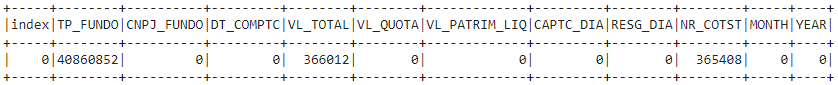
* Remoção dos *outliers* utilizando o algoritmo ECOD. A estratégia utilizada foir remover 1% dos "piores" dados de cada coluna, o que totalizou uma remoção de 6% do total dos dados brutos.

## Número de dados faltantantes para cada coluna

In [16]:
df.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns]).show()

+--------+----------+---------+--------+--------+-------------+---------+--------+--------+-----+-------------+---------------+----+
|TP_FUNDO|CNPJ_FUNDO|DT_COMPTC|VL_TOTAL|VL_QUOTA|VL_PATRIM_LIQ|CAPTC_DIA|RESG_DIA|NR_COTST|index|MONTH_OF_YEAR|QUARTER_OF_YEAR|YEAR|
+--------+----------+---------+--------+--------+-------------+---------+--------+--------+-----+-------------+---------------+----+
|38226889|         0|        0|       0|       0|            0|        0|       0|       0|    0|            0|              0|   0|
+--------+----------+---------+--------+--------+-------------+---------+--------+--------+-----+-------------+---------------+----+



## Coluna `TP_FUNDO`

### Quantidade de tipos de fundo diferentes

In [17]:
f'São ao todo {df.select("TP_FUNDO").distinct().count()} diferentes de fundos na base de dados.'

'São ao todo 12 diferentes de fundos na base de dados.'

Sendo eles:

In [18]:
df.select('TP_FUNDO').distinct().toPandas()

,TP_FUNDO
0,FI
1,FAPI
2,None
3,FIIM
4,FMP-FGTS
5,FIF
6,FIFDIV
7,FIC-FITVM
8,FIEX
9,FITVM


### Contagem de dados para cada tipo de fundo

In [19]:
count_fundo = df.groupBy('TP_FUNDO').count().sort('count').toPandas()
count_fundo.at[11, 'TP_FUNDO'] = 'Não definido' # modifica-se o valor None em TP_FUNDO para que seja possível plotar o gráfico de barras horizontais

In [20]:
count_fundo

,TP_FUNDO,count
0,FIIM,110
1,FIFDIV,201
2,FMP-FGTS CL,3995
3,FAPI,5763
4,FIEX,7435
5,FIC-FITVM,14460
6,FMP-FGTS,48784
7,FITVM,81414
8,FIF,448774
9,FACFIF,449456


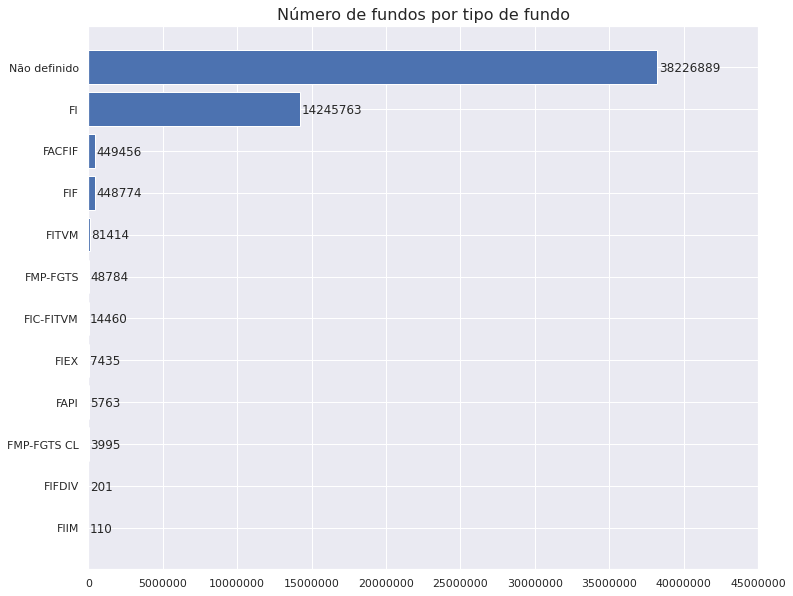

In [21]:
plt.figure(figsize= (12, 10))
plt.ticklabel_format(style= 'plain')
bars = plt.barh(y= count_fundo['TP_FUNDO'], width= count_fundo['count'])

for index, bar in enumerate(bars):
  plt.text(bar.get_width() + 100000, index - 0.1, bar.get_width(), fontsize= 12)

plt.title('Número de fundos por tipo de fundo', fontsize= 16)
plt.xlim([0, 45000000])
plt.show()

Há uma quantidade absurda de dados faltantes na coluna `TP_FUNDO`. Esses dados estão concentrados nos anos:

In [22]:
df.groupBy('YEAR', 'TP_FUNDO').count().sort('YEAR').show(n= 200)

+----+-----------+-------+
|YEAR|   TP_FUNDO|  count|
+----+-----------+-------+
|2001|      FITVM|      1|
|2002|  FIC-FITVM|      4|
|2002|   FMP-FGTS|      9|
|2002|      FITVM|    156|
|2003|      FITVM|    175|
|2003|  FIC-FITVM|     16|
|2003|   FMP-FGTS|     11|
|2003|        FIF|      4|
|2004|  FIC-FITVM|  14440|
|2004|FMP-FGTS CL|   1268|
|2004|     FIFDIV|    201|
|2004|       FIEX|   7435|
|2004|         FI|   1350|
|2004|   FMP-FGTS|  15714|
|2004|        FIF| 448770|
|2004|      FITVM|  81082|
|2004|       FIIM|    110|
|2004|     FACFIF| 449456|
|2005|       null|1329280|
|2006|       null|1375844|
|2007|       null|1621264|
|2008|       null|1912990|
|2009|       null|1907235|
|2010|       null|2155226|
|2011|       null|2415862|
|2012|       null|2600325|
|2013|       null|2890042|
|2014|       null|3059532|
|2015|       null|3043170|
|2016|       null|3060074|
|2017|       null|3166730|
|2018|       null|3355353|
|2019|FMP-FGTS CL|    105|
|2019|         FI| 321016|
|

Entre 2005 e 2018 todos os dados não possuem especificação quanto ao tipo de fundo. 

## Coluna `VL_TOTAL`

### Estatísticas descritivas

In [23]:
df.describe('VL_TOTAL').show(truncate= False)

+-------+--------------------+
|summary|VL_TOTAL            |
+-------+--------------------+
|count  |53533044            |
|mean   |1.5141681747704542E8|
|stddev |3.617127322129501E8 |
|min    |277316.79           |
|max    |1.014072060706E10   |
+-------+--------------------+



### Análise por trimestre (`QUARTER_OF_YEAR`)

In [24]:
avg_total_per_quarter = df.groupBy('QUARTER_OF_YEAR').agg(f.avg('VL_TOTAL')).orderBy('QUARTER_OF_YEAR').toPandas()

In [25]:
fig = px.line(
    data_frame= avg_total_per_quarter,
    x= 'QUARTER_OF_YEAR',
    y= 'avg(VL_TOTAL)',
    markers= True,
    title= 'Média trimestral do VL_TOTAL entre 2000 e 2023'
)
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Trimestres', yaxis_title= 'Média do VL_TOTAL')
fig.show()

### Análise por ano (`YEAR`)

In [26]:
avg_total_per_year = df.groupBy('YEAR').agg(f.avg('VL_TOTAL')).orderBy('YEAR').toPandas()

In [27]:
fig = px.line(
    data_frame= avg_total_per_year,
    x= 'YEAR',
    y= 'avg(VL_TOTAL)',
    markers= True,
    title= 'Média anual do VL_TOTAL entre 2000 e 2023'
)
fig.update_traces(line_color= 'red')
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Anos', yaxis_title= 'Média do VL_TOTAL')
fig.show()

## Coluna `VL_QUOTA`

### Análise da média trimestral (`QUARTER_OF_YEAR`)

In [28]:
avg_quota_per_quarter = df.groupBy('QUARTER_OF_YEAR').agg(f.avg('VL_QUOTA')).orderBy('QUARTER_OF_YEAR').toPandas()

In [29]:
fig = px.line(
    data_frame= avg_quota_per_quarter,
    x= 'QUARTER_OF_YEAR',
    y= 'avg(VL_QUOTA)',
    markers= True,
    title= 'Média trimestral do VL_QUOTA entre 2000 e 2023'
)
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Trimestres', yaxis_title= 'Média do VL_QUOTA')
fig.show()

### Análise da média anual (`YEAR`)

In [30]:
avg_quota_per_year = df.groupBy('YEAR').agg(f.avg('VL_QUOTA')).orderBy('YEAR').toPandas()

In [31]:
fig = px.line(
    data_frame= avg_quota_per_year,
    x= 'YEAR',
    y= 'avg(VL_QUOTA)',
    markers= True,
    title= 'Média anual do VL_QUOTA entre 2000 e 2023'
)
fig.update_traces(line_color= 'red')
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Anos', yaxis_title= 'Média do VL_QUOTA')
fig.show()

## Coluna `VL_PATRIM_LIQ`

### Análise da média trimestral (`QUARTER_OF_YEAR`)

In [32]:
avg_patrim_per_quarter = df.groupBy('QUARTER_OF_YEAR').agg(f.avg('VL_PATRIM_LIQ')).orderBy('QUARTER_OF_YEAR').toPandas()

In [33]:
fig = px.line(
    data_frame= avg_patrim_per_quarter,
    x= 'QUARTER_OF_YEAR',
    y= 'avg(VL_PATRIM_LIQ)',
    markers= True,
    title= 'Média trimestral do VL_PATRIM_LIQ entre 2000 e 2023'
)
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Trimestres', yaxis_title= 'Média do VL_PATRIM_LIQ')
fig.show()

In [34]:
avg_patrim_per_year = df.groupBy('YEAR').agg(f.avg('VL_PATRIM_LIQ')).orderBy('YEAR').toPandas()

In [35]:
fig = px.line(
    data_frame= avg_patrim_per_year,
    x= 'YEAR',
    y= 'avg(VL_PATRIM_LIQ)',
    markers= True,
    title= 'Média anual do VL_PATRIM_LIQ entre 2000 e 2023'
)
fig.update_traces(line_color= 'red')
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Anos', yaxis_title= 'Média do VL_PATRIM_LIQ')
fig.show()

## Coluna `CAPTC_DIA`

### Estatísticas descritivas

In [36]:
df.describe('CAPTC_DIA').show(truncate= False)

+-------+------------------+
|summary|CAPTC_DIA         |
+-------+------------------+
|count  |53533044          |
|mean   |188487.71169928904|
|stddev |1029021.3923677284|
|min    |0.0               |
|max    |1.57E7            |
+-------+------------------+



### Análise das médias trimestrais (`QUARTER_OF_YEAR`)

In [37]:
avg_captc_per_quarter = df.groupBy('QUARTER_OF_YEAR').agg(f.avg('CAPTC_DIA')).orderBy('QUARTER_OF_YEAR').toPandas()

In [38]:
fig = px.line(
    data_frame= avg_captc_per_quarter,
    x= 'QUARTER_OF_YEAR',
    y= 'avg(CAPTC_DIA)',
    markers= True,
    title= 'Médias trimestrais da CAPTC_DIA entre 2000 e 2023'
)
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Trimestres', yaxis_title= 'Média da CAPTC_DIA')
fig.show()

### Análise das médias anuais (`YEAR`)

In [39]:
avg_captc_per_year = df.groupBy('YEAR').agg(f.avg('CAPTC_DIA')).orderBy('YEAR').toPandas()

In [40]:
fig = px.line(
    data_frame= avg_captc_per_year,
    x= 'YEAR',
    y= 'avg(CAPTC_DIA)',
    markers= True,
    title= 'Médias anuais da CAPTC_DIA entre 2000 e 2023'
)
fig.update_traces(line_color= 'red')
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Anos', yaxis_title= 'Média da CAPTC_DIA')

## Coluna `RESG_DIA`

### Estatísticas descritivas

In [41]:
df.describe('RESG_DIA').show(truncate= False)

+-------+------------------+
|summary|RESG_DIA          |
+-------+------------------+
|count  |53533044          |
|mean   |145915.57700765674|
|stddev |699782.3732787843 |
|min    |0.0               |
|max    |9000000.0         |
+-------+------------------+



### Análise das médias trimestrais (`QUARTER_OF_YEAR`)

In [42]:
avg_resg_per_quarter = df.groupBy('QUARTER_OF_YEAR').agg(f.avg('RESG_DIA')).orderBy('QUARTER_OF_YEAR').toPandas()

In [43]:
fig = px.line(
    data_frame= avg_resg_per_quarter,
    x= 'QUARTER_OF_YEAR',
    y= 'avg(RESG_DIA)',
    markers= True,
    title= 'Médias trimestrais do RESG_DIA entre 2000 e 2023'
)
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Trimestres', yaxis_title= 'Média de RESG_DIA')
fig.show()

### Análise das médias anuais (`YEAR`)

In [44]:
avg_resg_per_year = df.groupBy('YEAR').agg(f.avg('RESG_DIA')).orderBy('YEAR').toPandas()

In [45]:
fig = px.line(
    data_frame= avg_resg_per_year,
    x= 'YEAR',
    y= 'avg(RESG_DIA)',
    markers= True,
    title= 'Médias anuais de RESG_DIA entre 2000 e 2023'
)
fig.update_traces(line_color= 'red')
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Anos', yaxis_title= 'Média de RESG_DIA')
fig.show()

## Coluna `NR_COTST`

### Estatísticas descritivas

In [46]:
df.describe('NR_COTST').show(truncate= False)

+-------+-----------------+
|summary|NR_COTST         |
+-------+-----------------+
|count  |53533044         |
|mean   |202.9699501489211|
|stddev |952.0314955899174|
|min    |1.0              |
|max    |12095.0          |
+-------+-----------------+



### Análise das médias trimestrais (`QUARTER_OF_YEAR`)

In [47]:
avg_cotst_per_quarter = df.groupBy('QUARTER_OF_YEAR').agg(f.avg('NR_COTST')).orderBy('QUARTER_OF_YEAR').toPandas()

In [48]:
fig = px.line(
    data_frame= avg_cotst_per_quarter,
    x= 'QUARTER_OF_YEAR',
    y= 'avg(NR_COTST)',
    markers= True,
    title= 'Médias trimestrais do NR_COTST entre 2000 e 2023'
)
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Trimestres', yaxis_title= 'Média do NR_COTST')
fig.show()

### Análise das médias anuais (`YEAR`)

In [49]:
avg_cotst_per_year = df.groupBy('YEAR').agg(f.avg('NR_COTST')).orderBy('YEAR').toPandas()

In [50]:
fig = px.line(
    data_frame= avg_cotst_per_year,
    x= 'YEAR',
    y= 'avg(NR_COTST)',
    markers= True,
    title= 'Médias anuais do NR_COTST entre 2000 e 2023'
)
fig.update_traces(line_color= 'red')
fig.update_layout(title= {'x': 0.5}, xaxis_title= 'Anos', yaxis_title= 'Média do NR_COTST')
fig.show()

# Análise gráfica com informações cruzadas

In [55]:
from plotly.subplots import make_subplots

## `VL_TOTAL` e `VL_PATRIM_LIQ`

In [58]:
fig = make_subplots(specs= [[{'secondary_y': True}]])

fig.add_trace(
    go.Scatter(x= avg_total_per_quarter['QUARTER_OF_YEAR'], y= avg_total_per_quarter['avg(VL_TOTAL)'], name= 'VL_TOTAL'), secondary_y= False
)
fig.add_trace(
    go.Scatter(x= avg_patrim_per_quarter['QUARTER_OF_YEAR'], y= avg_patrim_per_quarter['avg(VL_PATRIM_LIQ)'], name= 'VL_PATRIM_LIQ', 
               line= dict(dash= 'dot')), secondary_y= True
)
fig.update_layout(title_text= 'Time series das variáveis VL_TOTAL e VL_PATRIM_LIQ entre 2000 e 2023', title= {'x': 0.5})
fig.update_xaxes(title= 'Trimestres')
fig.update_yaxes(title= 'Médias da VL_TOTAL', secondary_y= False)
fig.update_yaxes(title= 'Médias do VL_PATRIM_LIQ', secondary_y= True)
fig.show()

## `CAPTC_DIA` e `RESG_DIA`

In [62]:
fig = make_subplots(specs= [[{'secondary_y': True}]])

fig.add_trace(
    go.Scatter(x= avg_captc_per_quarter['QUARTER_OF_YEAR'], y= avg_captc_per_quarter['avg(CAPTC_DIA)'], name= 'CAPTC_DIA'), secondary_y= False
)
fig.add_trace(
    go.Scatter(x= avg_resg_per_quarter['QUARTER_OF_YEAR'], y= avg_resg_per_quarter['avg(RESG_DIA)'], name= 'RESG_DIA', line=  
               dict(dash= 'dash')), secondary_y= True
)
fig.update_layout(title_text= 'Time series das variáveis CAPTC_DIA e RESG_DIA entre 2000 e 2023', title= {'x': 0.5})
fig.update_xaxes(title= 'Trimestres')
fig.update_yaxes(title= 'Médias da CAPTC_DIA', secondary_y= False)
fig.update_yaxes(title= 'Médias do RESG_DIA', secondary_y= True)
fig.show()

## `VL_QUOTA` e `NR_COTST`

In [64]:
fig = make_subplots(specs= [[{'secondary_y': True}]])

fig.add_trace(
    go.Scatter(x= avg_quota_per_quarter['QUARTER_OF_YEAR'], y= avg_quota_per_quarter['avg(VL_QUOTA)'], name= 'VL_QUOTA',
               line= dict(color= 'red')), secondary_y= False
)
fig.add_trace(
    go.Scatter(x= avg_cotst_per_quarter['QUARTER_OF_YEAR'], y= avg_cotst_per_quarter['avg(NR_COTST)'], name= 'NR_COTST', 
               line= dict(color= 'green', dash='dash')), secondary_y= True
)
fig.update_layout(title_text= 'Time series das variáveis VL_QUOTA e NR_COTST entre 2000 e 2023', title= {'x': 0.5})
fig.update_xaxes(title= 'Trimestres')
fig.update_yaxes(title= 'Médias do VL_QUOTA', secondary_y= False)
fig.update_yaxes(title= 'Médias do NR_COTST', secondary_y= True)
fig.show()

## `VL_PATRIM LIQ` e `CAPTC_DIA`

In [66]:
fig = make_subplots(specs= [[{'secondary_y': True}]])

fig.add_trace(
    go.Scatter(x= avg_patrim_per_quarter['QUARTER_OF_YEAR'], y= avg_patrim_per_quarter['avg(VL_PATRIM_LIQ)'], name= 'VL_PATRIM_LIQ'), secondary_y= False
)
fig.add_trace(
    go.Scatter(x= avg_captc_per_quarter['QUARTER_OF_YEAR'], y= avg_captc_per_quarter['avg(CAPTC_DIA)'], name= 'CAPTC_DIA', 
               line= dict(dash= 'dot')), secondary_y= True
)
fig.update_layout(title_text= 'Time series das variáveis VL_PATRIM_LIQ e CAPTC_DIA entre 2000 e 2023', title= {'x': 0.5})
fig.update_xaxes(title= 'Trimestres')
fig.update_yaxes(title= 'Médias da VL_PATRIM_LIQ', secondary_y= False)
fig.update_yaxes(title= 'Médias do CAPTC_DIA', secondary_y= True)
fig.show()

## `VL_PATRIM_LIQ` e `RESG_DIA`

In [67]:
fig = make_subplots(specs= [[{'secondary_y': True}]])

fig.add_trace(
    go.Scatter(x= avg_patrim_per_quarter['QUARTER_OF_YEAR'], y= avg_patrim_per_quarter['avg(VL_PATRIM_LIQ)'], name= 'VL_PATRIM_LIQ'), secondary_y= False
)
fig.add_trace(
    go.Scatter(x= avg_resg_per_quarter['QUARTER_OF_YEAR'], y= avg_resg_per_quarter['avg(RESG_DIA)'], name= 'RESG_DIA', 
               line= dict(dash= 'dot')), secondary_y= True
)
fig.update_layout(title_text= 'Time series das variáveis VL_PATRIM_LIQ e RESG_DIA entre 2000 e 2023', title= {'x': 0.5})
fig.update_xaxes(title= 'Trimestres')
fig.update_yaxes(title= 'Médias da VL_PATRIM_LIQ', secondary_y= False)
fig.update_yaxes(title= 'Médias do RESG_DIA', secondary_y= True)
fig.show()